In [1]:
from extract_style import StyleExtractor
from audio2exp import get_motion_seq
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.manifold import TSNE
import random

In [2]:
device = 'cuda'

exp_name = 'se_deca_run-240909_104413'
exp_iter = 22000
checkpoint_path = f'experiments/SE/{exp_name}/checkpoints/iter_{exp_iter:07}.pt'

extractor = StyleExtractor(checkpoint_path, device=device)

/mnt/data2/ketan/DiffPoseTalk/extract_style.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_data = torch.load(checkpoint_path, map_location=device)


In [ ]:
data_dir_1 = '/mnt/data2/anirudh/processed_videos/TH_00221/000'
data_dir_2 = '/mnt/data2/anirudh/processed_videos/WDA_BradSchneider/000'

params_dir_1 = os.path.join(data_dir_1, 'uv_data', 'params')
params_dir_2 = os.path.join(data_dir_2, 'uv_data', 'params')

motion_seq_1 = get_motion_seq(params_dir_1)
motion_seq_2 = get_motion_seq(params_dir_2)

len(motion_seq_1['exp']), len(motion_seq_2['exp'])

In [ ]:
style_feat_1_1 = extractor.extract(motion_seq_1, start_frame=0)
style_feat_1_2 = extractor.extract(motion_seq_1, start_frame=200)

In [ ]:
style_feat_2_1 = extractor.extract(motion_seq_2, start_frame=0)
style_feat_2_2 = extractor.extract(motion_seq_2, start_frame=200)

In [ ]:
np.linalg.norm(style_feat_1_1 - style_feat_1_2), np.linalg.norm(style_feat_1_1 - style_feat_2_1) 

In [ ]:
np.linalg.norm(style_feat_2_1 - style_feat_2_2), np.linalg.norm(style_feat_2_1 - style_feat_1_1) 

In [19]:
def sample_keys(keys_file_path, n):
    with open(keys_file_path, 'r') as file:
        lines = file.readlines()

    if n > len(lines):
        n = len(lines)

    sampled_lines = random.sample(lines, n)

    sampled_keys = [line.strip() for line in sampled_lines]

    return sampled_keys

In [24]:
train_keys_file_path = '/mnt/data2/anirudh/3DLipSync/diffposetalk/tfhp_hdtf_dataset/train.txt'
list_train_keys = sample_keys(train_keys_file_path, n=1000)

val_keys_file_path = '/mnt/data2/anirudh/3DLipSync/diffposetalk/tfhp_hdtf_dataset/val.txt'
list_val_keys = sample_keys(val_keys_file_path, n=100)

In [7]:
def get_style_vectors(data_dir, n=5):
    params_dir = os.path.join(data_dir, 'uv_data', 'params')
    motion_seq = get_motion_seq(params_dir)

    list_styles = []
    
    if len(motion_seq['exp']) < n * 100:
        return None

    for i in range(n):
        style = extractor.extract(motion_seq, start_frame=100*i)
        list_styles.append(style)

    return list_styles

In [21]:
def visualize_styles(data_dirs):
    # Collect all vectors and labels
    all_vectors = []
    all_labels = []
    colors = sns.color_palette("hsv", len(data_dirs))  # Use a distinct color for each data_dir

    for i, data_dir in enumerate(data_dirs):
        list_styles = get_style_vectors(data_dir)
        if list_styles == None:
            continue
        all_vectors.extend(list_styles)
        all_labels.extend([i] * len(list_styles))

    # Convert to numpy arrays
    all_vectors = np.array(all_vectors)
    all_labels = np.array(all_labels)

    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    reduced_vectors = tsne.fit_transform(all_vectors)

    # Plot the results
    plt.figure(figsize=(10, 8))
    for i, color in enumerate(colors):
        mask = (all_labels == i)
        plt.scatter(reduced_vectors[mask, 0], reduced_vectors[mask, 1], color=color, label=f'Data Dir {i}', alpha=0.7)

    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.title('t-SNE Visualization of Style Vectors')
    plt.show()

In [25]:
base_dir = '/mnt/data2/anirudh/processed_videos'
data_dirs_train = [os.path.join(base_dir, train_key) for train_key in list_train_keys]
data_dirs_val = [os.path.join(base_dir, train_key) for train_key in list_val_keys]

In [ ]:
visualize_styles(data_dirs_train)

100%|████████████████████████████████████| 1229/1229 [00:00<00:00, 4729.63it/s]


100%|████████████████████████████████████| 8577/8577 [00:00<00:00, 9621.92it/s]


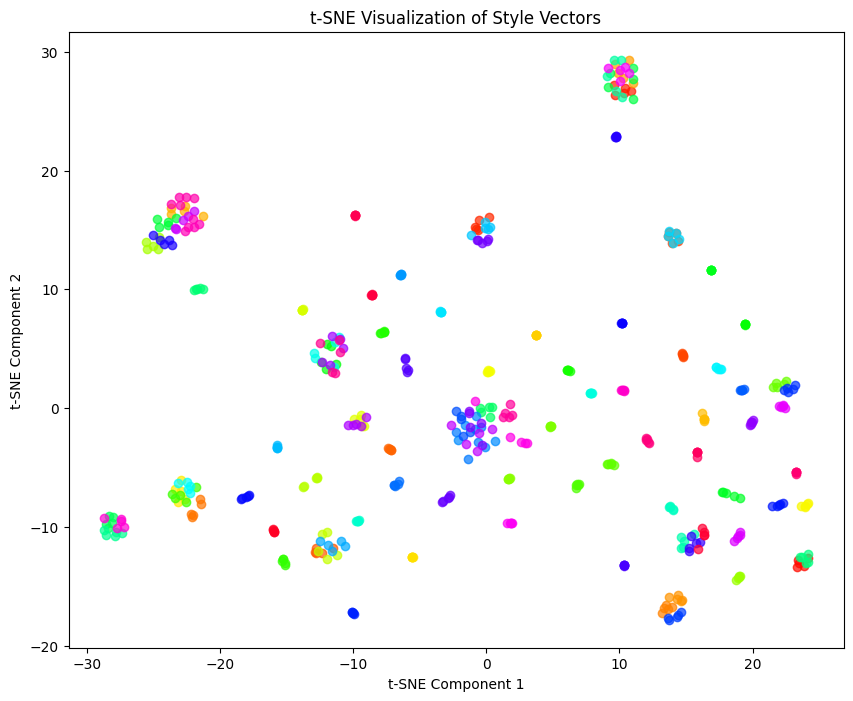

In [23]:
visualize_styles(data_dirs_val)